# Most Recent Image Processing

In [1]:
#imports
from __future__ import print_function
from PIL import Image, ImageDraw, ImageEnhance
import numpy as np
import cv2
import skimage
from scipy import ndimage as ndi
from skimage import feature, color,io
from skimage.morphology import square
import matplotlib.pyplot as plt
import math
from skimage.transform import probabilistic_hough_line
from builtins import input
import argparse

### Read in Image + Basic Filtering 
The "hand.img" is the one from the repo.

### Our image
select whatever image you like, there should be several to pick from. I don;t use any useful naming convetion to organize the images haha other than cropped.

(-0.5, 3279.5, 2463.5, -0.5)

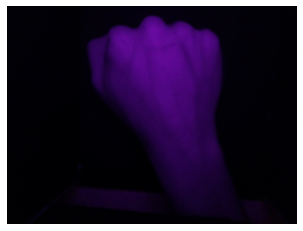

In [31]:
# Read in image and display
img = plt.imread('Image10.jpg')
plt.imshow(img,cmap=plt.cm.gray)
plt.axis('off')


### Adjusting 
Run this first (the code block above just veiws the image)

The code below reads in and converts to greyscale -> saved as test.jpg

<ipython-input-37-7834998abe88>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = color.rgb2gray(img)


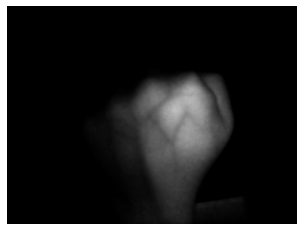

In [37]:
# Read in image and Choose color channel
img = plt.imread('Image16.jpg')
img=img[:,:,2] # gets color channel 

# adjust contrast (these parameters can be palyed with) #gamma 3 to start
img = skimage.exposure.adjust_gamma(img, gamma=2, gain=1)

# Chnage to grayscale and show
gray = color.rgb2gray(img)
plt.imshow(img,cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('test.jpg', bbox_inches='tight', pad_inches=0, dpi = 300) #loop 2 0.8 loop 1 1.5

# convert format
pi = Image.fromarray(img)

### Loc mean -- This seems to work best for now

Trying stuff from before, reads in the greyscale image from before (test) and then applies filters.

Saved as test3

<ipython-input-38-4d935701d940>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = color.rgb2gray(img)


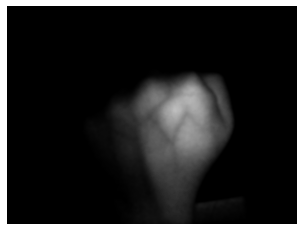

In [38]:
img = plt.imread('test.jpg')
img=img[:,:,2] # get color channel

# adjust contrast

gray = color.rgb2gray(img)

from skimage.morphology import disk
from skimage.filters.rank import mean
loc_mean = mean(img, disk(5))
plt.imshow(loc_mean, vmin=0, vmax=255, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('test3.jpg', bbox_inches='tight', pad_inches=0, dpi = 300) #loop 2 0.8 loop 1 1.5

### Using Image enhancer

This is oppisite of what we're trying to do ! this is get to get hand edge

<ipython-input-39-6060ee4394bc>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = color.rgb2gray(img)


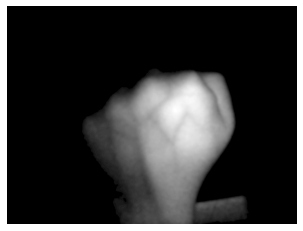

In [39]:
# Read in image and Choose color channel
img = plt.imread('test3.jpg')
img=img[:,:,1] # gets color channel 

# adjust contrast (these parameters can be palyed with) #gamma 3 to start
img = skimage.exposure.adjust_gamma(img, gamma=0.50, gain=0.95)

# Chnage to grayscale and show
gray = color.rgb2gray(img)
plt.imshow(img,cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('test2.jpg', bbox_inches='tight', pad_inches=0, dpi = 300) #loop 2 0.8 loop 1 1.5

# convert format
pi = Image.fromarray(img)

# Meijering Filter


Run 3x to try each images

test = raw image turned greyscale (no-prepocessing)

test3 = Localized mean filterd - some pre-processing

test2 = Image contrast enhance - some pre-processing (not coupled with other pre-processing, each is seperate)

(-0.5, 1204.5, 905.5, -0.5)

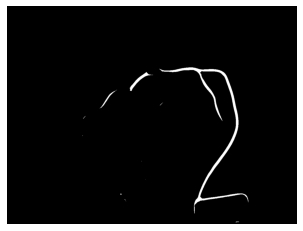

In [41]:
# Filter using meijering - Umage.enhance
img = plt.imread('test2.jpg')
img = skimage.filters.meijering(img,black_ridges=True)

# Turn to gray
gray = color.rgb2gray(img)

# Threshold and turn to binary
threshold = skimage.filters.threshold_otsu(gray)
binary = (gray >= threshold)

# Filter noise -erosion filter
hand_filt = ndi.morphology.binary_erosion(binary, iterations=6)

# Show image
plt.imshow(hand_filt, cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 1204.5, 905.5, -0.5)

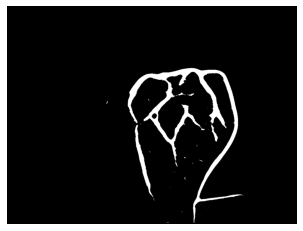

In [40]:
# Filter using meijering - loc mean
img = plt.imread('test3.jpg')
img = skimage.filters.meijering(img,black_ridges=True)

# Turn to gray
gray = color.rgb2gray(img)

# Threshold and turn to binary
threshold = skimage.filters.threshold_otsu(gray)
binary = (gray >= threshold)

# Filter noise -erosion filter
out = ndi.morphology.binary_erosion(binary, iterations=5)

# Show image
plt.imshow(out, cmap=plt.cm.gray)
plt.axis('off')

# Normal analysis now! 

out is reuslt of post-merijing! choose one of three and run right before

### Create copy to filter out outer hand


(-0.5, 1204.5, 905.5, -0.5)

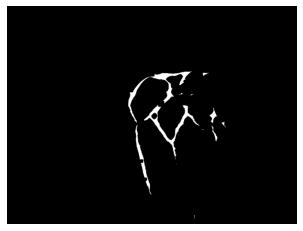

In [44]:
# Copy Image - Use this now
out1=out
filt=hand_filt

# make edge bigger
filt=skimage.morphology.dilation(filt,square(10))

#Convert (from True+False to 1,0's)
filt=filt*1
out1=out1*1

# Combine masks
combined = cv2.bitwise_xor(filt, out1) 
combined = cv2.bitwise_and(combined, out1)

# Filter noise -erosion filter
final = ndi.morphology.binary_erosion(combined, iterations=2)

# Show image - FIltered out outer hand
plt.imshow(final, cmap=plt.cm.gray)
plt.axis('off')

### Get Skeleton Image (edges)

(-0.5, 1204.5, 905.5, -0.5)

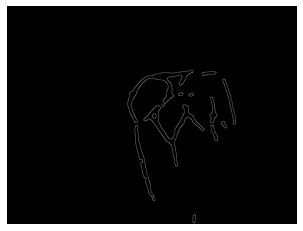

In [45]:
edges = feature.canny(combined, sigma = 5, low_threshold = 0.01, high_threshold = 0.2)

# Show Image
plt.imshow(edges, cmap=plt.cm.gray) # turn to gray
plt.axis('off')

### Transform to Hough Using edge image

(-0.5, 1204.5, 905.5, -0.5)

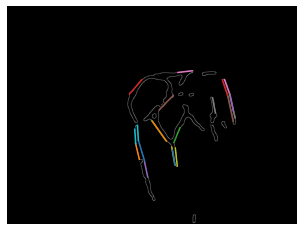

In [51]:
# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=20, line_length=60, line_gap=10)

# Show previous image (overlaying)
plt.imshow(edges, cmap=plt.cm.gray)

slope=[] # save slopes for later processing

# plot new lines
for line in lines:
    # Calculate Radius between parallel line to find thickest veins
        p0, p1 = line
        slope.append(abs(p0[0]-p1[0])/abs(p0[1]-p1[1])) # calculate slope of each line 
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

# Add title 

#plt.title('Probabilistic Hough')
plt.axis('off')

### Fucntions Used to post-process further

**mid_line_dist:**
Finds the distance between 2 lines from thier midpoints

Takes in 2 lines defined by 2 points (see below bc its weird)

Outputs distance (linear)

e.g) line=( (x1,x2),(y1,y2) )

In [42]:
def mid_line_dist(line1,line2,slope1):
    
    
    # get point from lines
    pointa1,pointa2=line1
    pointb1,pointb2=line2
    
    
    # Get y-inter
    b_line1=pointa1[1]-slope1*pointa1[0] #b=y-mx
    b_line2=pointb1[1]-slope1*pointb1[0]
    
    # calc distance
    parallel_dist1= abs(b_line2-b_line1)/(np.sqrt((slope1**2)+1))

    # comment out - Testing/visualizing
    '''
    plt.plot(pointa1[0],pointa1[1],'r*')
    plt.plot(pointa2[0],pointa2[1],'r*')
    plt.plot(pointb1[0],pointb1[1],'c*')
    plt.plot(pointb2[0],pointb2[1],'c*')
    '''
    
    return parallel_dist1
    

**Plot_connect:**
Plots a line bewteen 2 lines at thier midpoint

Takes in 2 lines defined by 2 points (see below bc its weird)

No ouput, adds to figure that is already open

e.g) line=( (x1,x2),(y1,y2) )

In [43]:
def plot_connect(line1,line2):
    p0,p1=line1
    xa,xb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    p0,p1=line2
    ya,yb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    plt.plot((xa,ya),(xb,yb))
    return

**Get_mid:**
Gets mid point between 2 lines at their midpoint 

Takes in 2 lines defined by 2 points (see below bc its weird)

Outputs a single point

In [44]:
def get_mid(line1,line2):
    p0,p1=line1
    xa,xb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    p0,p1=line2
    ya,yb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    
    xf=(xa+ya)/2
    yf=(yb+xb)/2
    return (xf,yf)

### GO through all slopes and find ones that are similar 

In [45]:
# Find Parallel Lines that are ~close~

thresh =0.07 # error between slopes

# Create empty lists to stroe data 
thick=[-1]*len(lines)
ind_parallel=[-1]*len(lines)

# loop through all slopes and compare slope i to all other slopes
for i in range(len(slope)):
    
    # inner loop to compare to others
    for j in range(0,len(slope)):
        # j==i = itself
        if j==i:
            continue
            
       # compute pairs of slopes that are within threshold 
        if abs(slope[i]-slope[j])<thresh and mid_line_dist(lines[i],lines[j],slope[j])<50 and mid_line_dist(lines[i],lines[j],slope[j])>5 :
            ind_parallel[i]=j # provides index
            
            # get all thicknesses of good slopes - used later for thickest vein
            thick[i]=(mid_line_dist(lines[i],lines[j],slope[i]))
            
            break # we only want 1 slope 

In [46]:
# Filter pairs that don't match

for i in ind_parallel:
    if i ==-1:
        continue
    else:
        if ind_parallel.index(i)!=ind_parallel[i]:
            print(i,ind_parallel[i])
            ind_parallel[ind_parallel.index(i)]=-1

### Show intermediate post-processing

- SOmething is wrong here 

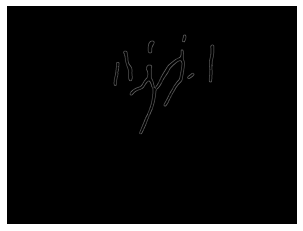

In [47]:
# SHow previous image
plt.imshow(edges, cmap=plt.cm.gray)
plt.axis('off')

# plot parallels and connectors
for i in range(len(lines)):
    if ind_parallel[i]==-1:
        continue
    else:
        
        line1=lines[i]
        line2=lines[ind_parallel[i]]
        
        pointa1,pointa2=line1
        pointb1,pointb2=line2
        
        plt.plot((pointa1[0],pointa2[0]),(pointa1[1],pointa2[1]),'r')
        #plt.plot(pointa2[0],pointa2[1],'r*')
        plt.plot((pointb1[0],pointb2[0]),(pointb1[1],pointb2[1]),'c')
        
        plt.plot()
        
        #plot_connect(line1,line2)
        

### Plot Best Access Point = Thickest vein form parallel lines

(-0.5, 1204.5, 905.5, -0.5)

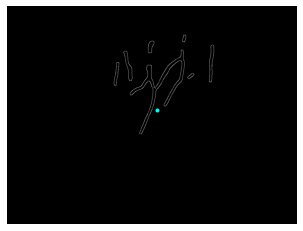

In [48]:
# Show previous image
plt.imshow(edges, cmap=plt.cm.gray)

# Get thickest vein by using max()
b_ind=thick.index(max(thick))
line1=lines[b_ind]
p0, p1 = line1


line2=lines[ind_parallel[b_ind]]
p0, p1 = line2
#plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

pnt=get_mid(line1,line2)


plt.plot(pnt[0],pnt[1], marker='o', markersize=3, color="cyan")
plt.axis('off')